# Fig9: Conditional correlations in the STG

In [1]:
import numpy as np
import matplotlib.pylab as plt
import delfi.distribution as dd
import time
from copy import deepcopy
import sys
sys.path.append("../fig8_stg/model/setup")
sys.path.append("../fig8_stg/model/simulator")
sys.path.append("../fig8_stg/model/inference")
sys.path.append("../fig8_stg/model/visualization")
sys.path.append("../fig8_stg/model/utils")

import sys; sys.path.append('../')
from common import col, svg, plot_pdf, samples_nd, buildCondCovMatrix, extractSpecificCondCorr

import netio
import viz
import importlib
import viz_samples
import train_utils as tu

import matplotlib as mpl

%load_ext autoreload
%autoreload 2

In [2]:
PANEL_A  = 'svg/31D_panel_a.svg'
PANEL_B1  = 'svg/31D_panel_b1.svg'
PANEL_B2  = 'svg/31D_panel_b2.svg'
PANEL_C  = 'svg/31D_panel_c.svg'
PANEL_C2 = 'svg/31D_panel_c2.svg'
PANEL_D = 'svg/31D_panel_d.svg'
PANEL_E1 = 'svg/31D_panel_e1.svg'
PANEL_E2 = 'svg/31D_panel_e2.svg'

PANEL_X1params = 'svg/31D_panel_App1_params.svg'
PANEL_X2params = 'svg/31D_panel_App2_params.svg'
PANEL_X1ss = 'svg/31D_panel_App1_ss.svg'
PANEL_X2ss = 'svg/31D_panel_App2_ss.svg'

PANEL_X = 'svg/31D_panel_x.svg'

### Load samples

In [3]:
params = netio.load_setup('train_31D_R1_BigPaper')

In [4]:
filedir = "../fig8_stg/results/31D_samples/pyloricsamples_31D_noNaN_3.npz"
pilot_data, trn_data, params_mean, params_std = tu.load_trn_data_normalize(filedir, params)
print('We use', len(trn_data[0]), 'training samples.')

stats = trn_data[1]
stats_mean = np.mean(stats, axis=0)
stats_std  = np.std(stats, axis=0)

We use 170000 training samples.


### Load network

In [5]:
date_today = '1908208'
import dill as pickle
with open('../fig8_stg/results/31D_nets/191001_seed1_Exper11deg.pkl', 'rb') as file:
    inf_SNPE_MAF, log, params = pickle.load(file)
params = netio.load_setup('train_31D_R1_BigPaper')

In [6]:
prior = netio.create_prior(params, log=True)
dimensions = np.sum(params.use_membrane) + 7
lims = np.asarray([-np.sqrt(3)*np.ones(dimensions), np.sqrt(3)*np.ones(dimensions)]).T

In [7]:
prior = netio.create_prior(params, log=True)
params_mean = prior.mean
params_std = prior.std

In [8]:
from find_pyloric import merge_samples, params_are_bounded

labels_ = viz.get_labels(params)
prior_normalized = dd.Uniform(-np.sqrt(3)*np.ones(dimensions), np.sqrt(3)*np.ones(dimensions), seed=params.seed)

### Load experimental data

In [9]:
summstats_experimental = np.load('../fig8_stg/results/31D_experimental/190807_summstats_prep845_082_0044.npz')['summ_stats']

### Calculate posterior

In [10]:
from find_pyloric import merge_samples, params_are_bounded

all_paths = []
all_posteriors = []
labels_ = viz.get_labels(params)

posterior_MAF = inf_SNPE_MAF.predict([summstats_experimental]) # given the current sample, we now predict the posterior given our simulation outcome. Note that this could just be overfitted.

### Load samples

In [11]:
samples_MAF = merge_samples("../fig8_stg/results/31D_samples/02_cond_vals", name='conductance_params')
samples_MAF = np.reshape(samples_MAF, (1000*2520, 31))
print(np.shape(samples_MAF))

(2520000, 31)


### Load start and end point

In [12]:
num_to_watch = 3
infile = '../fig8_stg/results/31D_pairs/similar_and_good/sample_pair_{}.npz'.format(num_to_watch) # 0 is shitty
npz = np.load(infile)
start_point = npz['params1']
end_point = npz['params2']

In [13]:
start_point_unnorm = start_point * params_std + params_mean
end_point_unnorm   = end_point   * params_std + params_mean
ratio = end_point_unnorm / start_point_unnorm
run_true = (ratio > np.ones_like(ratio) * 2.0) | (ratio < np.ones_like(ratio) / 2.0)

In [14]:
print(run_true)

[ True  True False  True False False  True False False False False  True
  True False False False False False False False  True False  True False
 False False False False False False False]


In [17]:
lims = np.asarray([-np.sqrt(3)*np.ones(dimensions), np.sqrt(3)*np.ones(dimensions)]).T
#lims[-7,1] -= 2*np.sqrt(3)/6

In [20]:
condition=[samples_MAF[23]]

In [21]:
print(condition)

[array([ 0.36870709,  0.94398522,  0.70361459,  0.23584956,  0.72013789,
       -0.08273453, -0.0159445 , -1.1242677 ,  1.10892916,  0.30762386,
       -1.03168511, -1.22857141,  1.46345222,  0.22603768, -0.2999846 ,
       -0.16751139,  0.09787674, -0.20366697,  0.98973262,  0.05867213,
       -1.34967172, -0.97141302,  0.86625403, -0.39365372,  0.79057515,
       -1.56889021,  0.1520375 ,  1.23345423,  1.37947774, -0.82434475,
        1.31542718])]


# Panel A: marginal posterior

In [16]:
from decimal import Decimal
all_labels = []
for dim_i in range(31):
    if dim_i > len(params_mean) - 7.5: # synapses
        if dim_i == 24: all_labels.append([r'$\mathdefault{0.01}$   ', r'$\mathdefault{10000}\;\;\;\;$   '])
        else: all_labels.append([r'$\;\;\mathdefault{0.01}$', r'$\mathdefault{1000}\;\;\;\;$ '])
    else: # membrane conductances
        num_after_digits = -int(np.log10(lims[dim_i, 1] * params_std[dim_i] + params_mean[dim_i]))
        if num_after_digits > 2:
            num_after_digits=2
        labels = [round(Decimal((lims[dim_i, num_tmp] * params_std[dim_i] + params_mean[dim_i]) / 0.628e-3), num_after_digits)
                  for num_tmp in range(2)]
        new_labels = []
        counter=0
        for l in labels:
            if counter == 0:
                new_labels.append(r'$\mathdefault{'+str(l)+'}$')
            else:
                new_labels.append(r'$\mathdefault{'+str(l)+'}\;\;\;$ ')
            counter+=1
        all_labels.append(new_labels)

../common.py:589: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if opts['labels'] == [] or opts['labels'] is None:


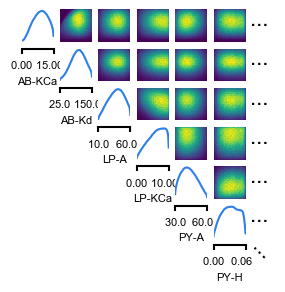

In [213]:
import matplotlib.patheffects as pe

with mpl.rc_context(fname='../.matplotlibrc'):

    labels_ = viz.get_labels_8pt(params)
    labels_[9] += ''

    fig, axes = samples_nd(samples=[samples_MAF[:2520000]],
                           subset=[4,5,11,12,19,22], # ,25,26,28
                           limits=lims,
                           ticks=lims,
                           tick_labels=all_labels,
                           fig_size=(17.0*0.17, 17.0*0.17),
                           labels=labels_,
                           scatter_offdiag={'rasterized':True, 'alpha':1.0},
                           samples_colors=[col['SNPE']],
                           diag=['kde'],
                           upper=['hist'],
                           hist_offdiag={'bins':50})
    
    plt.savefig(PANEL_A, facecolor='None', transparent=True)
    plt.show()

# Panel B: Conditional posteriors

../common.py:589: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if opts['labels'] == [] or opts['labels'] is None:


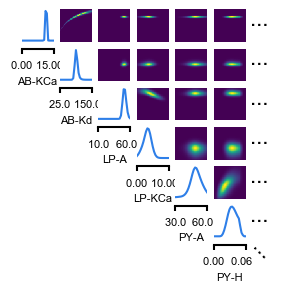

In [52]:
import matplotlib.patheffects as pe

with mpl.rc_context(fname='../.matplotlibrc'):

    labels_ = viz.get_labels_8pt(params)
    labels_[9] += ''

    fig, axes = samples_nd(pdfs=[posterior_MAF],
                           samples=[samples_MAF[:12600]],
                           subset=[4,5,11,12,19,22], # ,25,26,28
                           limits=lims,
                           ticks=lims,
                           tick_labels=all_labels,
                           fig_size=(17.0*0.17,17.0*0.17),
                           labels=labels_,
                           #points=[samples_MAF[7]],
                           scatter_offdiag={'rasterized':True, 'alpha':1.0},
                           #points_offdiag={'marker':'o', 'markeredgecolor':'w', 'markersize':3.6, 'markeredgewidth':0.5, 'path_effects':[pe.Stroke(linewidth=1.2, foreground='k'), pe.Normal()]},
                           points_colors=[col['CONSISTENT1']],
                           samples_colors=[col['SNPE']],
                           condition=[samples_MAF[7]],
                           diag=['cond'],
                           upper=['cond'],
                           hist_offdiag={'bins':50})
    
    plt.savefig(PANEL_B1, facecolor='None', transparent=True)
    plt.show()

../common.py:589: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if opts['labels'] == [] or opts['labels'] is None:


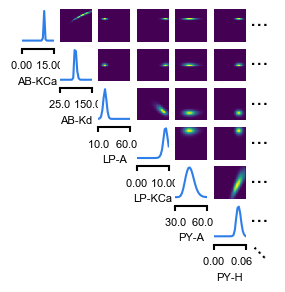

In [84]:
import matplotlib.patheffects as pe

with mpl.rc_context(fname='../.matplotlibrc'):

    labels_ = viz.get_labels_8pt(params)
    labels_[9] += ''

    fig, axes = samples_nd(pdfs=[posterior_MAF],
                           samples=[samples_MAF[:12600]],
                           subset=[4,5,11,12,19,22], # ,25,26,28
                           limits=lims,
                           ticks=lims,
                           tick_labels=all_labels,
                           fig_size=(17.0*0.17, 17.0*0.17),
                           labels=labels_,
                           #points=[samples_MAF[1]],
                           scatter_offdiag={'rasterized':True, 'alpha':1.0},
                           #points_offdiag={'marker':'o', 'markeredgecolor':'w', 'markersize':3.6, 'markeredgewidth':0.5, 'path_effects':[pe.Stroke(linewidth=1.2, foreground='k'), pe.Normal()]},
                           points_colors=[col['CONSISTENT1']],
                           samples_colors=[col['SNPE']],
                           condition=[samples_MAF[23]], # 1 # 23 # 26 # 28
                           diag=['cond'],
                           upper=['cond'],
                           hist_offdiag={'bins':50})
    
    plt.savefig(PANEL_B2, facecolor='None', transparent=True)
    plt.show()

# Panel C: Correlation matrix for marginal

In [17]:
rho = np.corrcoef(samples_MAF.T)

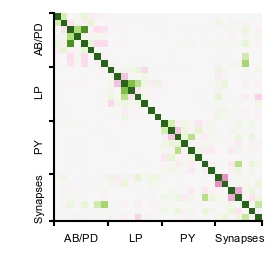

In [18]:
with mpl.rc_context(fname='../.matplotlibrc'):

    fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(2.7,2.7))
    ax.imshow(rho, clim=[-1.0, 1.0], cmap='PiYG')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    
    plt.xticks([-0.5, 7.5, 15.5, 23.5, 30.5], (r'$\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\mathdefault{AB/PD}$',
                                               r'$\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\mathdefault{LP}$',
                                               r'$\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\mathdefault{PY}$',
                                               r'$\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\mathdefault{Synapses}$',''))
    plt.yticks([-0.5, 7.5, 15.5, 23.5, 30.5], ('AB/PD    ','LP       ','PY       ','Synapses ',''))
    plt.yticks(rotation=90)

    #plt.savefig(PANEL_C, facecolor='None', transparent=True)
    plt.show()

# Panel D: Average corrlelation matrix for conditionals

In [19]:
import time

In [20]:
max_dim     = 31
num_samples = 500
resolution  = 50
start_t = time.time()
rho_symm_save = buildCondCovMatrix(posterior_MAF, lims=lims, samples=samples_MAF[:num_samples], num_samples=num_samples, max_dim=max_dim, resolution=resolution)
print('For', num_samples, 'samples, it took:  ', time.time()-start_t)
np.savez('results/cond_cov_{}samples_{}resolution.npz'.format(num_samples, resolution), rho_symm=rho_symm_save)

mdnewcounter 0
mdnewcounter 1
mdnewcounter 2
mdnewcounter 3
mdnewcounter 4
mdnewcounter 5
mdnewcounter 6
mdnewcounter 7
mdnewcounter 8
mdnewcounter 9
mdnewcounter 10
mdnewcounter 11
mdnewcounter 12
mdnewcounter 13
mdnewcounter 14
mdnewcounter 15
mdnewcounter 16
mdnewcounter 17
mdnewcounter 18
mdnewcounter 19
mdnewcounter 20
mdnewcounter 21
mdnewcounter 22
mdnewcounter 23
mdnewcounter 24
mdnewcounter 25
mdnewcounter 26
mdnewcounter 27
mdnewcounter 28
mdnewcounter 29
mdnewcounter 30
mdnewcounter 31
mdnewcounter 32
mdnewcounter 33
mdnewcounter 34
mdnewcounter 35
mdnewcounter 36
mdnewcounter 37
mdnewcounter 38
mdnewcounter 39
mdnewcounter 40
mdnewcounter 41
mdnewcounter 42
mdnewcounter 43
mdnewcounter 44
mdnewcounter 45
mdnewcounter 46
mdnewcounter 47
mdnewcounter 48
mdnewcounter 49
mdnewcounter 50
mdnewcounter 51
mdnewcounter 52
mdnewcounter 53
mdnewcounter 54
mdnewcounter 55
mdnewcounter 56
mdnewcounter 57
mdnewcounter 58
mdnewcounter 59
mdnewcounter 60
mdnewcounter 61
mdnewcounter 62
md

In [21]:
rho_symm = np.load('results/cond_cov_500samples_50resolution.npz')['rho_symm']

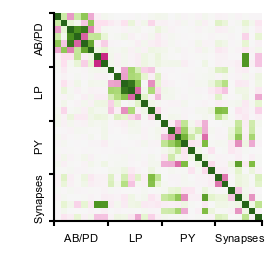

In [22]:
with mpl.rc_context(fname='../.matplotlibrc'):

    fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(2.7,2.7))
    mpb = ax.imshow(rho_symm, clim=[-1.0, 1.0], cmap='PiYG')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    
    plt.xticks([-0.5, 7.5, 15.5, 23.5, 30.5], (r'$\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\mathdefault{AB/PD}$',
                                               r'$\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\mathdefault{LP}$',
                                               r'$\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\mathdefault{PY}$',
                                               r'$\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\mathdefault{Synapses}$',''))
    plt.yticks([-0.5, 7.5, 15.5, 23.5, 30.5], ('AB/PD    ','LP       ','PY       ','Synapses ',''))
    plt.yticks(rotation=90)

    plt.savefig(PANEL_D, facecolor='None', transparent=True)
    plt.show()

# Panel C2: Colorbar

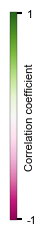

In [24]:
with mpl.rc_context(fname='../.matplotlibrc'):

    # draw a new figure and replot the colorbar there
    fig,ax = plt.subplots(figsize=(2.7,2.7))
    cb = plt.colorbar(mpb,ax=ax, aspect=30)

    #cb.outline.set_color('white')
    
    cb.outline.set_edgecolor('k')
    cb.outline.set_linewidth(0.2)

    cb.set_ticks([-0.99,0.99])  # vertically oriented colorbar
    cb.ax.set_yticklabels(['-1', '1'])  # vertically oriented colorbar
                           
    cb.ax.set_ylabel('Correlation coefficient')
    cb.ax.yaxis.labelpad = -8
    
    
    ax.remove()
    
    plt.savefig(PANEL_C2, facecolor='None', transparent=True)
    plt.show()

# Panel E: Extract specific correlations

In [25]:
num_samples = 500
specific_correlation_save = extractSpecificCondCorr(posterior_MAF, corrs=[[3,6], [11,14], [19,22], [6,28], [14,24], [14,25], [14,30], [22,26], [22,27], [22,29]], lims=lims, samples=samples_MAF[:num_samples], num_samples=num_samples, max_dim=max_dim, resolution=resolution)
np.savez('results/cond_cov_matrix/cond_specific_{}samples_{}resolution.npz'.format(num_samples, resolution), specific_correlation=specific_correlation_save)

In [26]:
specific_correlation = np.load('results/cond_cov_matrix/cond_specific_500samples_50resolution.npz')['specific_correlation']

In [27]:
num_membrane = 3

In [28]:
cmap = plt.cm.get_cmap('PiYG')

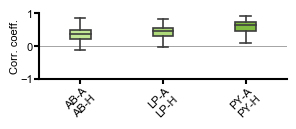

In [35]:
import seaborn as sns
import pandas as pd

with mpl.rc_context(fname='../.matplotlibrc'):
    fig, ax = plt.subplots(1,1, figsize=(3.2,0.85))
    df = pd.DataFrame(specific_correlation[:3].T)

    ax.axhline(0.0, c='gray', lw=.5)
    ax = sns.boxplot(data=df, width=0.25, fliersize=.0, linewidth=1.2) # , color='#0570b0'
    for i, patch in enumerate(ax.artists):
        r, g, b, a = patch.get_facecolor() # r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .6)) # patch.set_facecolor((r, g, b, .6))
        mean_val = np.mean(specific_correlation[i]) * 0.5 + 0.5
        rgba = cmap(mean_val)
        patch.set_facecolor((rgba[0], rgba[1], rgba[2])) # patch.set_facecolor((r, g, b, .6))
    plt.xticks(np.arange(3), ('AB-A\nAB-H', 'LP-A\nLP-H', 'PY-A\nPY-H'))
    plt.xticks(rotation=45)
    ax.tick_params(axis='both', which='major', pad=1)

    ax.set_ylim([-1,1])
    ax.set_xlim(-0.5, 2.5)
    
    ax.yaxis.labelpad = -0
    plt.ylabel('Corr. coeff.')
    
    plt.savefig(PANEL_E1, facecolor='None', transparent=True)
    plt.show()

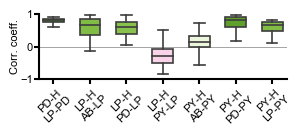

In [34]:
import seaborn as sns
import pandas as pd

with mpl.rc_context(fname='../.matplotlibrc'):
    fig, ax = plt.subplots(1,1, figsize=(3.2,0.85))
    df = pd.DataFrame(specific_correlation[3:].T)

    ax.axhline(0.0, c='gray', lw=.5, zorder=-10)
    ax = sns.boxplot(data=df, width=0.57, fliersize=.0, linewidth=1.2)
    for i, patch in enumerate(ax.artists):
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .6)) # patch.set_facecolor((r, g, b, .6))
        mean_val = np.mean(specific_correlation[i+3]) * 0.5 + 0.5
        rgba = cmap(mean_val)
        patch.set_facecolor((rgba[0], rgba[1], rgba[2])) # patch.set_facecolor((r, g, b, .6))
    plt.xticks(np.arange(len(specific_correlation)-num_membrane), ('PD-H\nLP-PD', 'LP-H\nAB-LP', 'LP-H\nPD-LP', 'LP-H\nPY-LP', 'PY-H\nAB-PY', 'PY-H\nPD-PY', 'PY-H\nLP-PY'))
    plt.xticks(rotation=45)
    ax.tick_params(axis='both', which='major', pad=1)
    
    ax.yaxis.labelpad = -0
    plt.ylabel('Corr. coeff.')

    ax.set_ylim([-1,1])
    ax.set_xlim(-0.4, 6.4)
    
    plt.savefig(PANEL_E2, facecolor='None', transparent=True)
    plt.show()

# Assemble figure

In [3]:
color_mixture = 0.5 * (np.asarray(list(col['CONSISTENT1'])) + np.asarray(list(col['CONSISTENT2'])))

In [4]:
import time
import IPython.display as IPd

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [5]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_heading = {'size': '8pt', 'font': 'Arial'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#D73789'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

sizefactor = 1.0
dshift = 0.5*factor_svg

top_left_x_AB = 295.9
top_left_y_AB = 287.4

top_left_x_1 = 380
top_left_y_1 = 355

top_left_x_2 = 333
top_left_y_2 = 306

top_left_x_3 = 429
top_left_y_3 = 402

square_size = 48.2
small_square = 6.0

rectangle_col = 'black'
smallRect_col = 'blue'
rectangle_width = 1.0
    
f = Figure('20.3cm', '13.2cm',

    Panel(
          SVG(PANEL_A).scale(svg_scale).move(0, 15*factor_svg),
          Text("a", 0*factor_svg, 17*factor_svg, **kwargs_text),
          #Text("Na CaT CaS A KCa Kd H leak", 6.5*factor_svg, 63.0*factor_svg, **kwargs_heading),
    ).move(0*factor_svg, -14.5*factor_svg),
    
    Panel(
          SVG(PANEL_B1).scale(svg_scale).move(0, 15*factor_svg),
          Text("c", 0*factor_svg, 17*factor_svg, **kwargs_text),
    ).move(48*factor_svg, -14.5*factor_svg),
    
    Panel(
          SVG(PANEL_B2).scale(svg_scale).move(0, 15*factor_svg),
    ).move(96*factor_svg, -14.5*factor_svg),
    
    Panel(
          SVG(PANEL_C).scale(svg_scale).move(0, 0*factor_svg),
          Text("b", 3*factor_svg, 0*factor_svg, **kwargs_text),
          #Text("Marginal covariance matrix", 8.5*factor_svg, 0.5*factor_svg, **kwargs_heading),
    ).move(-3*factor_svg, 50*factor_svg),
    
    Panel(
          SVG(PANEL_C2).scale(svg_scale).move(0, 0*factor_svg),
    ).move(39.5*factor_svg, 50*factor_svg),
    
    Panel(
          SVG(PANEL_D).scale(svg_scale).move(0, 0*factor_svg),
        Text("d", 3.0*factor_svg, 0*factor_svg, **kwargs_text),
        #Text("Conditional covariance matrix", 8.5*factor_svg, 0.5*factor_svg, **kwargs_heading),
    ).move(45.0*factor_svg, 50*factor_svg),
    
    Panel(
          SVG(PANEL_E1).scale(svg_scale).move(0, 0*factor_svg),
          Text("e", -1*factor_svg, 0*factor_svg, **kwargs_text),
          #Text("Experimentally observed correlations", 5*factor_svg, 0.5*factor_svg, **kwargs_heading),
    ).move(92.4*factor_svg, 50*factor_svg),
    
    Panel(
          SVG(PANEL_E2).scale(svg_scale).move(0, 0*factor_svg),
    ).move(92.4*factor_svg, 69.2*factor_svg),
    
    # AB/PD square
    Line(((top_left_x_AB, top_left_y_AB), (top_left_x_AB, top_left_y_AB+square_size)), width=rectangle_width, color=rectangle_col),
    Line(((top_left_x_AB, top_left_y_AB), (top_left_x_AB+square_size, top_left_y_AB)), width=rectangle_width, color=rectangle_col),
    Line(((top_left_x_AB+square_size, top_left_y_AB), (top_left_x_AB+square_size, top_left_y_AB+square_size)), width=rectangle_width, color=rectangle_col),
    Line(((top_left_x_AB, top_left_y_AB+square_size), (top_left_x_AB+square_size, top_left_y_AB+square_size)), width=rectangle_width, color=rectangle_col),
    
    # LP square
    Line(((top_left_x_AB+square_size, top_left_y_AB+square_size), (top_left_x_AB+square_size, top_left_y_AB+2*square_size)), width=rectangle_width, color=rectangle_col),
    Line(((top_left_x_AB+square_size, top_left_y_AB+square_size), (top_left_x_AB+2*square_size, top_left_y_AB+square_size)), width=rectangle_width, color=rectangle_col),
    Line(((top_left_x_AB+2*square_size, top_left_y_AB+square_size), (top_left_x_AB+2*square_size, top_left_y_AB+2*square_size)), width=rectangle_width, color=rectangle_col),
    Line(((top_left_x_AB+square_size, top_left_y_AB+2*square_size), (top_left_x_AB+2*square_size, top_left_y_AB+2*square_size)), width=rectangle_width, color=rectangle_col),
    
    # PY square
    Line(((top_left_x_AB+2*square_size, top_left_y_AB+2*square_size), (top_left_x_AB+2*square_size, top_left_y_AB+3*square_size)), width=rectangle_width, color=rectangle_col),
    Line(((top_left_x_AB+2*square_size, top_left_y_AB+2*square_size), (top_left_x_AB+3*square_size, top_left_y_AB+2*square_size)), width=rectangle_width, color=rectangle_col),
    Line(((top_left_x_AB+3*square_size, top_left_y_AB+2*square_size), (top_left_x_AB+3*square_size, top_left_y_AB+3*square_size)), width=rectangle_width, color=rectangle_col),
    Line(((top_left_x_AB+2*square_size, top_left_y_AB+3*square_size), (top_left_x_AB+3*square_size, top_left_y_AB+3*square_size)), width=rectangle_width, color=rectangle_col),
           
    # AB-A, AB-H square
    #Line(((top_left_x_1, top_left_y_1), (top_left_x_1, top_left_y_1+small_square)), width=rectangle_width, color=smallRect_col),
    #Line(((top_left_x_1, top_left_y_1), (top_left_x_1+small_square, top_left_y_1)), width=rectangle_width, color=smallRect_col),
    #Line(((top_left_x_1+small_square, top_left_y_1), (top_left_x_1+small_square, top_left_y_1+small_square)), width=rectangle_width, color=smallRect_col),
    #Line(((top_left_x_1, top_left_y_1+small_square), (top_left_x_1+small_square, top_left_y_1+small_square)), width=rectangle_width, color=smallRect_col),
           
    # AB-A, AB-H square
    #Line(((top_left_x_2, top_left_y_2), (top_left_x_2, top_left_y_2+small_square)), width=rectangle_width, color=smallRect_col),
    #Line(((top_left_x_2, top_left_y_2), (top_left_x_2+small_square, top_left_y_2)), width=rectangle_width, color=smallRect_col),
    #Line(((top_left_x_2+small_square, top_left_y_2), (top_left_x_2+small_square, top_left_y_2+small_square)), width=rectangle_width, color=smallRect_col),
    #Line(((top_left_x_2, top_left_y_2+small_square), (top_left_x_2+small_square, top_left_y_2+small_square)), width=rectangle_width, color=smallRect_col),
    
    # AB-A, AB-H square
    #Line(((top_left_x_3, top_left_y_3), (top_left_x_3, top_left_y_3+small_square)), width=rectangle_width, color=smallRect_col),
    #Line(((top_left_x_3, top_left_y_3), (top_left_x_3+small_square, top_left_y_3)), width=rectangle_width, color=smallRect_col),
    #Line(((top_left_x_3+small_square, top_left_y_3), (top_left_x_3+small_square, top_left_y_3+small_square)), width=rectangle_width, color=smallRect_col),
    #Line(((top_left_x_3, top_left_y_3+small_square), (top_left_x_3+small_square, top_left_y_3+small_square)), width=rectangle_width, color=smallRect_col),
)

!mkdir -p fig
f.save("fig/fig9_stg.svg")
svg('fig/fig9_stg.svg')